In [235]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [236]:
from phase_scan import PhaseScan

In [310]:
decimation_data = pd.read_csv("Decimation.csv")
pti_data = pd.read_csv("PTI_Inversion.csv")
plt.style.use('classic')

# DC Values

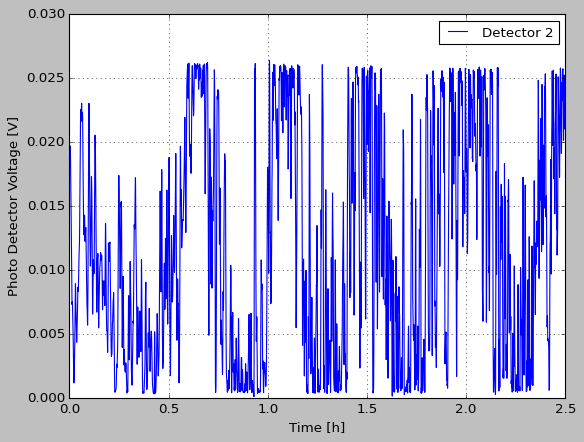

In [319]:
time = np.arange(len(decimation_data["DC1"])) / 3600
for channel in range(1, 2):
    plt.plot(time[:9000], decimation_data[f"DC{channel}"][:9000], label=f"Detector {channel}")
plt.xlabel("Time [h]", fontsize=12)
plt.ylabel("Photo Detector Voltage [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

# RMS Values

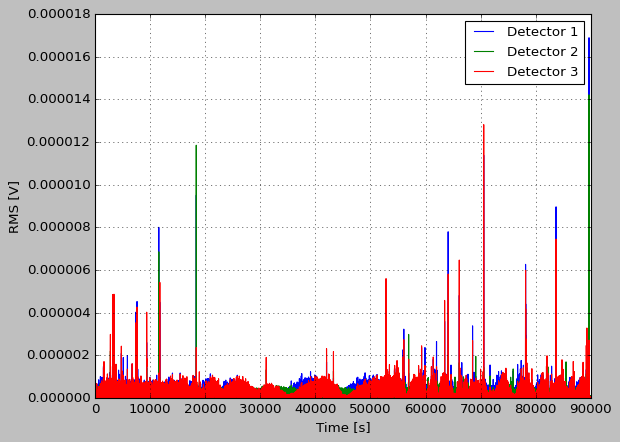

In [241]:
time = np.arange(len(decimation_data["X1"]))
for channel in range(1, 4):
    plt.plot(time, np.sqrt(decimation_data[f"X{channel}"] ** 2 + decimation_data[f"Y{channel}"] ** 2), label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)

# Response Phases

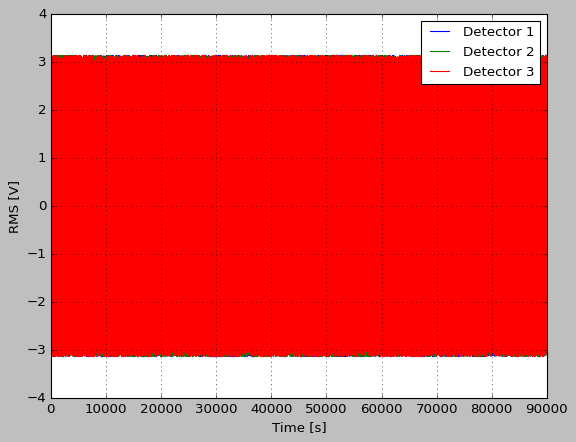

In [242]:
time = np.arange(len(decimation_data["X1"]))
for channel in range(1, 4):
    plt.plot(time, np.arctan2(decimation_data[f"Y{channel}"], decimation_data[f"X{channel}"]), label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()

# PTI Signal

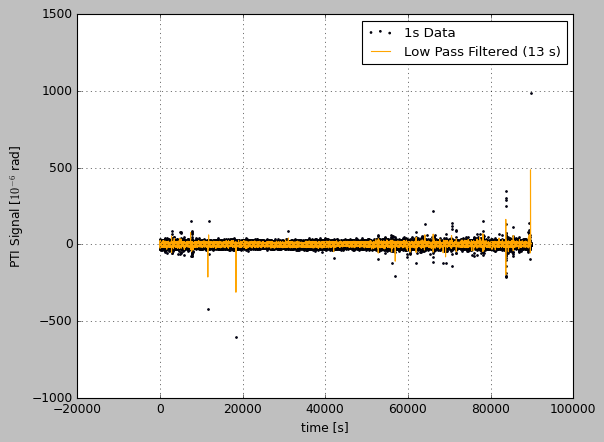

In [243]:
time = np.arange(len(pti_data["PTI Signal"]))
pti_mean = np.mean(np.array(pti_data["PTI Signal"]).reshape(-1, 2), axis=1)
time_mean = np.arange(pti_mean.size)
time_mean *= 2
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
plt.scatter(time, -pti_data["PTI Signal"] * 1e6, s=2, label="1s Data")
plt.plot(time_mean, -pti_mean * 1e6, label="Low Pass Filtered (13 s)", color="orange")
plt.grid()
plt.xlabel("time [s]", fontsize=11)
plt.legend(fontsize=12)
plt.ylabel("PTI Signal [$10^{-6}$ rad]", fontsize=11)
plt.show()

# Interferometric Phase

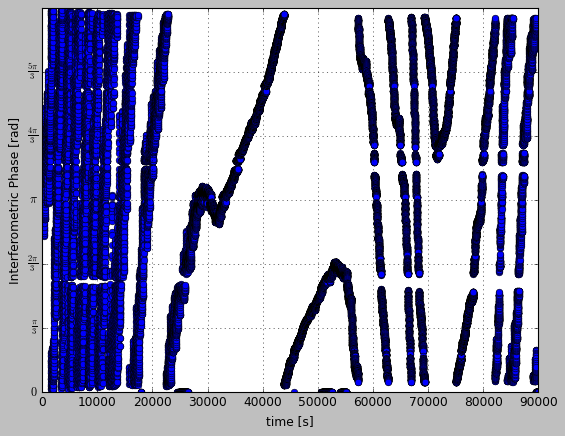

In [244]:
phases = pti_data["Interferometric Phase"].to_numpy()
phases[np.where(phases < 0)] += 2 * np.pi
_, ax = plt.subplots()
plt.yticks([0, np.pi / 3, 2 / 3 * np.pi, np.pi, 4 * np.pi / 3, 5 * np.pi / 3, 2 * np.pi],
           ['$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$', r'$\frac{4\pi}{3}$', r'$\frac{5\pi}{3}$', r'$2\pi$'])
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
plt.plot(time, phases, "o")
plt.grid()
plt.xlabel("time [s]", fontsize=11)
plt.ylabel("Interferometric Phase [rad]", fontsize=11)
plt.show()

# Automatic Phase Scan

## Distribution of the interferometric phases

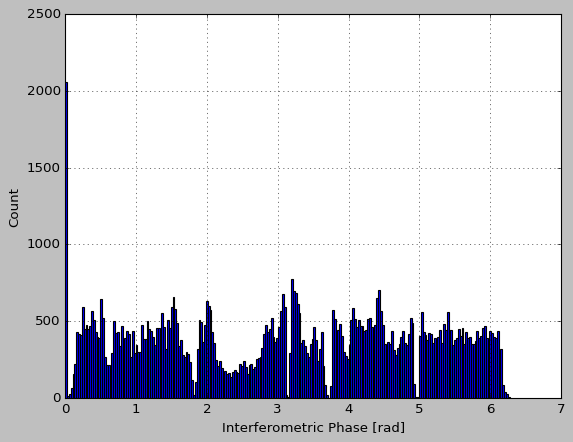

In [245]:
bins = plt.hist(phases, bins=240)
plt.grid()
plt.xlabel("Interferometric Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

The interferometric phase shows the trend to a uniform distribution. However, it seems like that their exist still interferometric phases
which have a higher occurrence than others.

## Basic Idea of Algorithm
Formally we represent the phases as a set of multi-sets. Therefor we discretize the range 0 to $2\pi$ into $n$ different values (basing on the histogram above it may be more useful to choice no equal steps). Formally we obtain a sequence $$a_i = \frac{2 \pi}{n}i$$
If it holds for a given phase $\varphi$ the following $$a_i \le \varphi < a_{i+1}$$ then we put $\varphi$ into the $i$-th multi-set. While every multiset is not empty we can calculate output phases with exactly one element of every multi set.

We can implement this by using a directed Graph where node $v_i$ represents $a_i$. Every child of node $v_i$ (and there children) is a measured interferometric phase. We can calculate the output phases iff a BFS counts exactly $n$ nodes. If the result is less than $n$ we are still missing phases to calculate the output phases.

<center>
    <img src="graph.png">

In the figure above a possible graph for the phases is shown.
</center>

<center>
<img src="graph_phasescan.png">

In the figure above a possible graph for the phases after a coloring is shown.
    </center>

## Implementation

In [246]:
import networkx as nx

In [247]:
G = nx.Graph()

In [248]:
n = 5
roots = []
for i in range(1, n):
    G.add_node(round(2 * np.pi / n * i, 2))
    roots.append(round(2 * np.pi / n * i, 2))

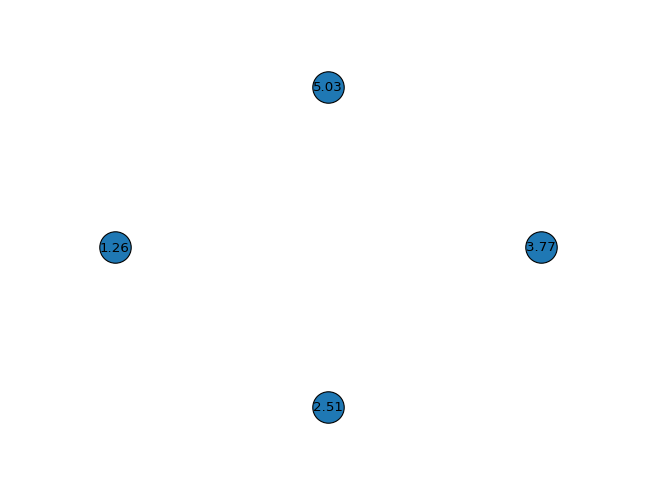

In [249]:
nx.draw_shell(G, with_labels=True, node_size=800)

In [250]:
for i in range(len(phases)):
    if i > 10:
        break
    k = int(n * phases[i] / (2 * np.pi))
    G.add_edge(i, list(G.nodes())[k])

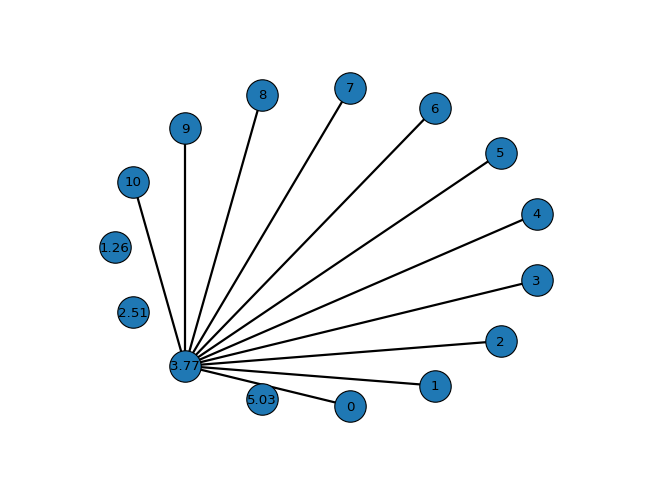

In [251]:
nx.draw_shell(G, with_labels=True, node_size=800, width=2)

The figure shows that the model works: every node is ordered to it's best-fit value. Every node $v_i$ of $a_i$ represents the root of a tree now. Hence we have a forest. Output phases can be calculated if the output degree of every node $v_i$ is at least 1.
If a node has an output degree > 1 we can color its node. If every tree has a colored node we can calculate with them the output phases and remove these nodes. At this moment the process repeats.

# Interial Seting of Parameters

In [253]:
def detector_1(signal, i):
    phi = np.arccos(signal[0])
    return lambda x: (np.cos(phi - x) - signal[i]) ** 2

def detector_2(signal, i):
    phi = 2 * np.pi - np.arccos(signal[0])
    return lambda x: (np.cos(phi - x) - signal[i]) ** 2

def detector_1_df(signal, i):
    phi = np.arccos(signal[0])
    return lambda x: 2 * (np.cos(phi - x) - signal[i]) * np.sin(phi - x)

def detector_2_df(signal, i):
    phi = 2 * np.pi - np.arccos(signal[0])
    return lambda x: 2 * (np.cos(phi - x) - signal[i]) * np.sin(phi - x)


In [372]:
data = np.array([decimation_data["DC1"][:10000], decimation_data["DC2"][:10000], decimation_data["DC3"][:10000]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()

min_values = []
max_values = []
t = 0
results_detector_1 = []
phases = []
results_detector_2 = []
last_time = 0
scaled = True
for i in range(5000):
    signal = np.array([decimation_data["DC1"][i], decimation_data["DC2"][i], decimation_data["DC3"][i]])
    for i in range(3):
        if signal[i] > phase_scan.max_intensities[i]:
            continue
        if signal[i] < phase_scan.min_intensities[i]:
            continue
    signal = 2 * (signal - phase_scan.min_intensities) / (phase_scan.max_intensities - phase_scan.min_intensities) - 1
    res_1 = minimize(detector_1(signal, 1), x0=1.8631947093343644, jac=detector_1_df(signal, 1)).x[0]
    res_2 = minimize(detector_2(signal, 1), x0=1.8631947093343644, jac=detector_2_df(signal, 1)).x[0]
    if np.abs(res_1 - 1.8631947093343644) < np.abs(res_2 - 1.8631947093343644):
        results_detector_1.append(res_1)
        phases.append(np.arccos(signal[0]))
        res_1 = minimize(detector_1(signal, 2), x0=3.76867851565287, jac=detector_1_df(signal, 2)).x[0]
        results_detector_2.append(res_1)
    else:
        results_detector_1.append(res_2)
        phases.append(2 * np.pi - np.arccos(signal[0]))
        res_2 = minimize(detector_2(signal, 2), x0=3.76867851565287, jac=detector_2_df(signal, 2)).x[0]
        results_detector_2.append(res_2)
    t += 1
    if False:
        phase_scan.set_data(np.array([decimation_data["DC1"][last_time:t],
                                      decimation_data["DC2"][last_time:t],
                                      decimation_data["DC3"][last_time:t]]).T)
        phase_scan.set_max()
        phase_scan.set_min()
        min_values.append(PhaseScan.min_intensities)
        max_values.append(PhaseScan.max_intensities)
        last_time = t

In [373]:
res = np.array(results_detector_1)
res2 = np.array(results_detector_2)

# $\pi$-Bands

If the contrast is not set properly, the min and max values cannot be reached. Since it is $|\max(\arccos{x})| = \pi$, this means values around $\pi$ will be skipped. This results in are of interferometric phase that is always skipped. The so-called $\pi$-band.
The $\pi$-Band is in the figure above as green dashed box shown.

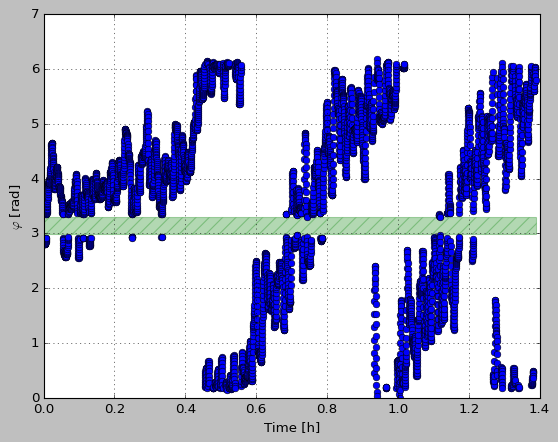

In [410]:
from matplotlib import patches
fig,ax = plt.subplots()
plt.plot(np.arange(len(phases)) / 3600, phases, "o")
rect = patches.Rectangle((0, 0.95 * np.pi), len(phases) / 3600 , 0.1 * np.pi, linewidth=1, hatch="//", alpha=0.3, color="green")
ax.add_patch(rect)
plt.xlabel("Time [h]")
plt.ylabel(r"$\varphi$ [rad]")
plt.grid()
plt.show()

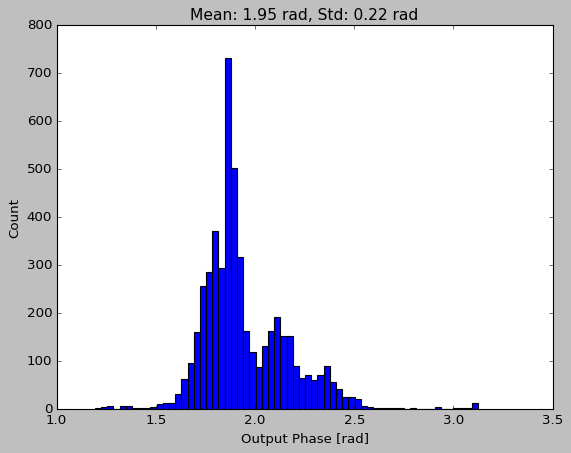

In [347]:
a = plt.hist(res, bins="auto")
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Mean: {round(np.mean(res), 2)} rad, Std: {round(np.std(res), 2)} rad", fontsize=14)
plt.plot()
plt.show()

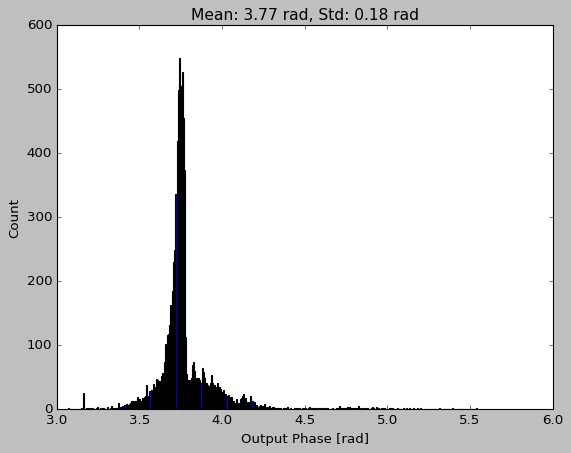

In [357]:
plt.hist(res2, bins="auto")
plt.style.use('classic')
plt.xlabel("Output Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Mean: {round(np.mean(res2), 2)} rad, Std: {round(np.std(res2), 2)} rad", fontsize=14)
plt.plot()
plt.savefig("detector_2.pdf")
plt.show()

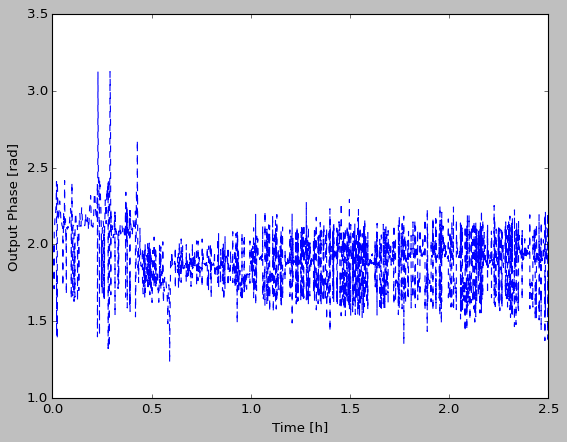

In [358]:
plt.plot(np.arange(len(res)) / 3600, res, "--")
plt.ylabel("Output Phase [rad]", fontsize=12)
plt.xlabel("Time [h]", fontsize=12)
plt.savefig("output_phase_1.pdf")

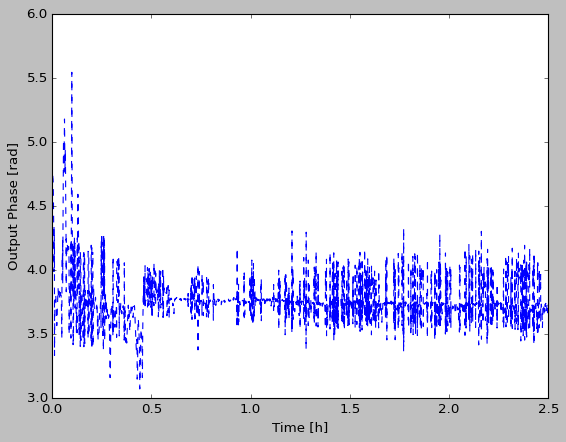

In [359]:
plt.plot(np.arange(len(res)) / 3600, res2, "--")
plt.ylabel("Output Phase [rad]", fontsize=12)
plt.xlabel("Time [h]", fontsize=12)
plt.savefig("output_phase_2.pdf")